In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.models import *
from keras import optimizers
from keras import metrics
from tensorflow import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd '/content/drive/MyDrive/DL_project'

/content/drive/MyDrive/DL_project


In [5]:
dir = '/content/drive/MyDrive/dataset/'

In [6]:
classes=['freshoranges',
        #  'freshbanana',
        #  'freshapples',
         ]

In [7]:
shape = (256, 256)

In [8]:
train_data = []

for i in range(len(classes)):
  path = dir + '/train/' + classes[i] + '/*.png'
  for filename in glob.glob(path):
    img = cv2.imread(filename)
    img = cv2.resize(img, shape)
    train_data.append(img)
train_data = np.array(train_data)
print(train_data.shape)

(1466, 256, 256, 3)


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train, x_val = train_test_split(train_data, test_size = 0.33, random_state = 42, shuffle = True)
# x_train, x_test = train_test_split(x_train, test_size = 0.33, random_state = 42, shuffle = True)
print(x_train.shape)
print(x_val.shape)

(982, 256, 256, 3)
(484, 256, 256, 3)


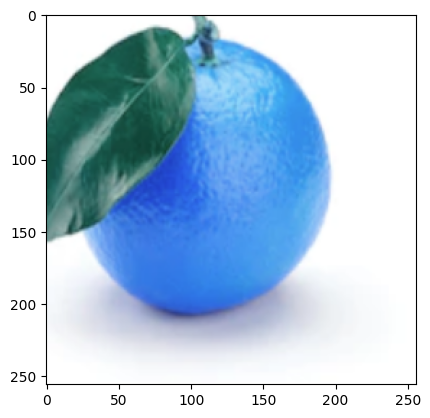

In [11]:
plt.imshow(x_train[0])

In [12]:
# x_train = x_train/255
# x_val = x_val/255

In [14]:
class build_cae_model(Model):
    def __init__(self, height = 32, width = 32, channel=0):
        """
        build convolutional autoencoder model
        """
        super(build_cae_model, self).__init__()
        self.encoder = Sequential([
                                Input(shape=(height, width, channel)),
                                Conv2D(16, 3, activation = 'relu', padding = 'same'),
                                Conv2D(16, 3, activation = 'relu', padding = 'same'),
                                BatchNormalization(),
                                MaxPooling2D(),
                                Conv2D(32, 3, activation = 'relu', padding = 'same'),
                                Conv2D(32, 3, activation = 'relu', padding = 'same'),
                                BatchNormalization(),
                                MaxPooling2D(),
                                Conv2D(32, 3, activation = 'relu', padding = 'same'),
                                Conv2D(64, 3, activation = 'relu', padding = 'same'),
                                Conv2D(64, 3, activation = 'relu', padding = 'same'),
                                BatchNormalization(),
                                MaxPooling2D(),
                                Conv2D(64, 3, activation = 'relu', padding = 'same'),
                                Conv2D(64, 3, activation = 'relu', padding = 'same'),
                                Conv2D(64, 3, activation = 'relu', padding = 'same'),
                                BatchNormalization(),
                                MaxPooling2D(),
                                Conv2D(128, 3, activation = 'relu', padding = 'same'),
                                Conv2D(128, 3, activation = 'relu', padding = 'same'),
                                Conv2D(256, 3, activation = 'relu', padding = 'same'),
                                BatchNormalization(),
                                MaxPooling2D(), # 8 x 8

        ])


        self.decoder = Sequential([
                                Input(shape=(8 , 8, 256)),
                                UpSampling2D(),
                                Conv2DTranspose(256, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(128, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(128, 3, activation = 'relu', padding = 'same'),
                                UpSampling2D(),
                                Conv2DTranspose(64, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(64, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(64, 3, activation = 'relu', padding = 'same'),
                                UpSampling2D(),
                                Conv2DTranspose(64, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(64, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(64, 3, activation = 'relu', padding = 'same'),
                                UpSampling2D(),
                                Conv2DTranspose(32, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(32, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(32, 3, activation = 'relu', padding = 'same'),
                                UpSampling2D(),
                                Conv2DTranspose(32, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(16, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(16, 3, activation = 'relu', padding = 'same'),
                                Conv2DTranspose(channel, 3, padding='same')
        ])

    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
model = build_cae_model(256, 256, 3)
# model.encoder.summary()

In [16]:
# model.decoder.summary()

In [17]:
def scheduler(epoch, lr):
  if epoch < 80:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [18]:
checkpoint_path =  'models/cae_orange/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-03, momentum=0.2),
    loss='mse'
)

In [20]:
history = model.fit(x_train, x_train,
          epochs = 150,
          batch_size = 30,
          validation_data = (x_val, x_val),
          callbacks = [lr_schedule, cp_callback])

Epoch 1/150
33/33 [==============================] - ETA: 0s - loss: 47091.2109
Epoch 1: saving model to models/cae_orange/cp.ckpt
33/33 [==============================] - 60s 825ms/step - loss: 47091.2109 - val_loss: 31989.7402 - lr: 0.0010
Epoch 2/150
33/33 [==============================] - ETA: 0s - loss: 37294.5469
Epoch 2: saving model to models/cae_orange/cp.ckpt
33/33 [==============================] - 18s 565ms/step - loss: 37294.5469 - val_loss: 32414.4570 - lr: 0.0010
Epoch 3/150
33/33 [==============================] - ETA: 0s - loss: 40964.5117
Epoch 3: saving model to models/cae_orange/cp.ckpt
33/33 [==============================] - 19s 577ms/step - loss: 40964.5117 - val_loss: 32103.0820 - lr: 0.0010
Epoch 4/150
33/33 [==============================] - ETA: 0s - loss: 30492.3594
Epoch 4: saving model to models/cae_orange/cp.ckpt
33/33 [==============================] - 19s 570ms/step - loss: 30492.3594 - val_loss: 16988.5371 - lr: 0.0010
Epoch 5/150
33/33 [=============

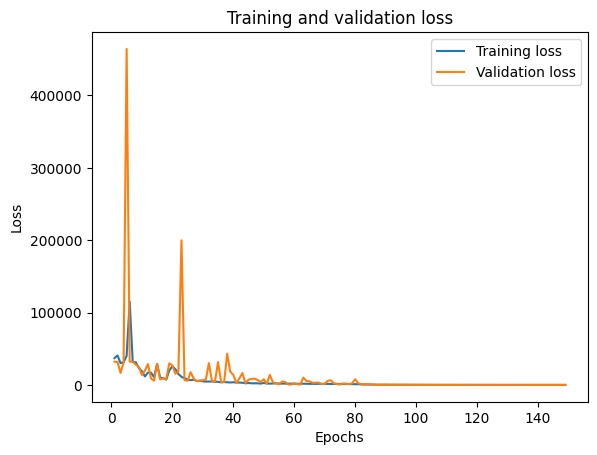

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(0, len(loss))
plt.plot(epochs[1:], loss[1:], label='Training loss')
plt.plot(epochs[1:], val_loss[1:], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
import pandas as pd

hist_df = pd.DataFrame(history.history)
hist_csv_file = 'history/cae_history_orange.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [5]:
model = tf.keras.models.load_model('/content/drive/MyDrive/DL_project/models/cae_orange/cp.ckpt/')

In [6]:
normal_test_apple = []

path = '/content/drive/MyDrive/dataset/test/freshoranges' + '/*.png'
for filename in glob.glob(path):
  img = cv2.imread(filename)
  img = cv2.resize(img, (256, 256))
  normal_test_apple.append(img)

normal_test_apple = np.array(normal_test_apple)
print(normal_test_apple.shape)

(388, 256, 256, 3)


In [7]:
abnormal_test_apple = []

path = '/content/drive/MyDrive/abnormal_test_data/orange' + '/*.png'
for filename in glob.glob(path):
  img = cv2.imread(filename)
  img = cv2.resize(img, (256, 256))
  img = img[:, :, ::-1]
  abnormal_test_apple.append(img)

abnormal_test_apple = np.array(abnormal_test_apple)
print(abnormal_test_apple.shape)

(388, 256, 256, 3)


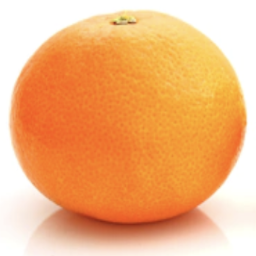

In [8]:
cv2_imshow(normal_test_apple[0])

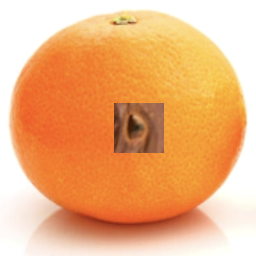

In [9]:
cv2_imshow(abnormal_test_apple[0])

In [10]:
reconstructions = model.predict(normal_test_apple)
reconstructions = np.array(reconstructions, dtype = 'float32')
normal_test_apple = np.array(normal_test_apple, dtype = 'float32')
normal_loss = tf.keras.losses.mse(reconstructions, normal_test_apple)
print(normal_loss.shape)

13/13 [==============================] - 13s 158ms/step
(388, 256, 256)


In [11]:
normal_score = []
for value in normal_loss:
  normal_score.append(np.array(value).mean())

<Figure size 640x480 with 0 Axes>

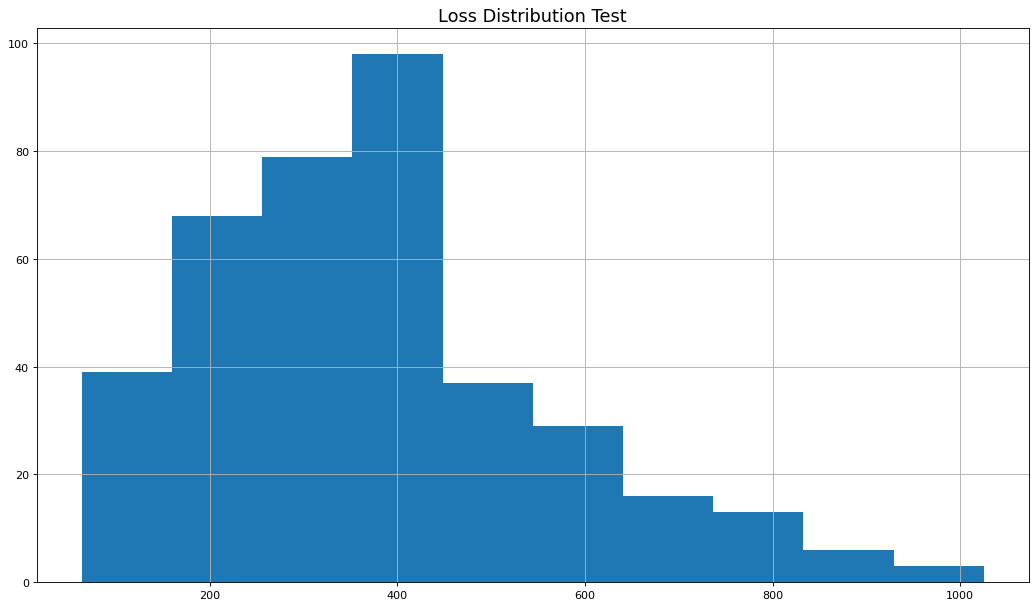

In [12]:
import seaborn as sns

plt.figure()
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution Test', fontsize=16)
plt.grid()
plt.hist(normal_score, bins = 10);

In [13]:
reconstructions_a = model.predict(abnormal_test_apple)
reconstructions_a = np.array(reconstructions_a, dtype = 'float32')
abnormal_test_apple = np.array(abnormal_test_apple, dtype = 'float32')
abnormal_loss = tf.keras.losses.mse(reconstructions_a, abnormal_test_apple)
print(abnormal_loss.shape)

13/13 [==============================] - 1s 86ms/step
(388, 256, 256)


In [14]:
abnormal_score = []
for value in abnormal_loss:
  abnormal_score.append(np.array(value).mean())

<Figure size 640x480 with 0 Axes>

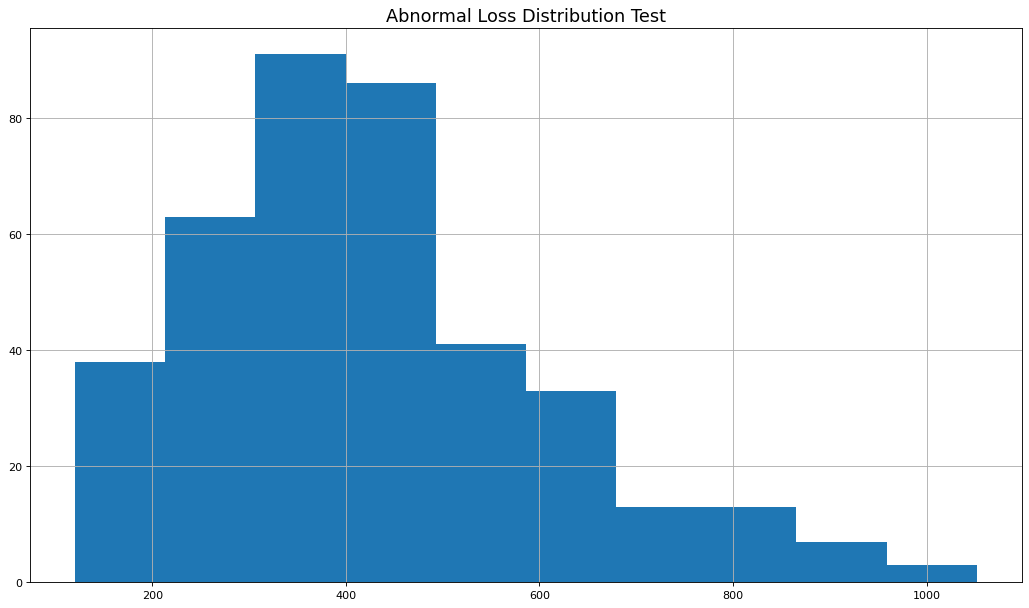

In [15]:
plt.figure()
plt.figure(figsize=(16,9), dpi=80)
plt.title('Abnormal Loss Distribution Test', fontsize=16)
plt.grid()
plt.hist(abnormal_score, bins = 10);

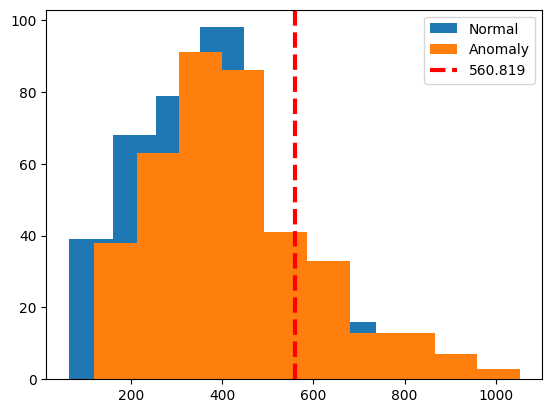

In [16]:
threshold = np.mean(normal_score) + np.std(normal_score)

plt.hist(normal_score, bins = 10, label = 'Normal')
plt.hist(abnormal_score, bins = 10, label = 'Anomaly')
plt.axvline(threshold, color='r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(threshold))
plt.legend(loc = 'upper right')
plt.show()

In [17]:
thresholds = np.linspace(min(normal_score), max(normal_score), 200)

In [18]:
def predict_score(threshold, normal_score, abnormal_score):
  pred_label = []
  for score in normal_score:
    if score <= threshold:
      pred_label.append(0)
    else:
      pred_label.append(1)
  for score in abnormal_score:
    if score <= threshold:
      pred_label.append(0)
    else:
      pred_label.append(1)

  return pred_label

In [19]:
true_label = np.concatenate((np.zeros((len(normal_score))), np.ones((len(abnormal_score)))))
len(true_label)

776

In [20]:
from sklearn import metrics

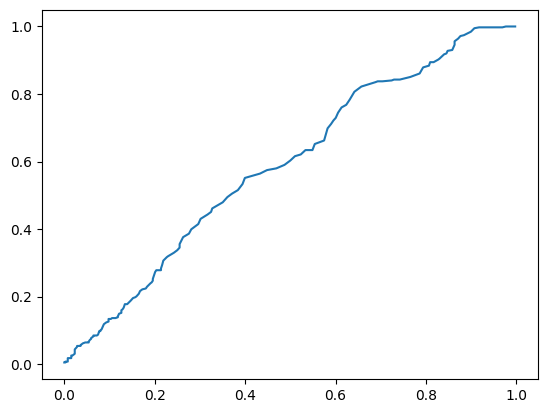

In [21]:
fprs = []; tprs = []

for threshold in thresholds:
  pred_label = predict_score(threshold, normal_score, abnormal_score)
  fpr, tpr, _ = metrics.roc_curve(true_label, pred_label)
  fprs.append(fpr[1])
  tprs.append(tpr[1])

tprs = np.array([np.array(val) for val in tprs])
fprs = np.array([np.array(val) for val in fprs])
plt.plot(fprs, tprs)
plt.show()

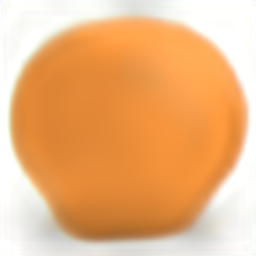

In [22]:
cv2_imshow(reconstructions[0])

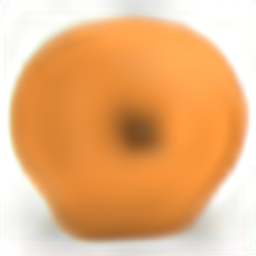

In [23]:
cv2_imshow(reconstructions_a[0])

In [24]:
rotten_test_apple = []

path = '/content/drive/MyDrive/dataset/test/rottenoranges' + '/*.png'
for filename in glob.glob(path):
  img = cv2.imread(filename)
  img = cv2.resize(img, (256, 256))
  img = img[:, :, ::-1]
  rotten_test_apple.append(img)

rotten_test_apple = np.array(rotten_test_apple)
print(rotten_test_apple.shape)

(403, 256, 256, 3)


In [25]:
reconstruction_b = model.predict(rotten_test_apple)
reconstruction_b = np.array(reconstruction_b, dtype = 'float32')
rotten_test_apple = np.array(rotten_test_apple, dtype = 'float32')
rotten_loss = tf.keras.losses.mse(reconstruction_b, rotten_test_apple)
print(rotten_loss.shape)

13/13 [==============================] - 3s 248ms/step
(403, 256, 256)


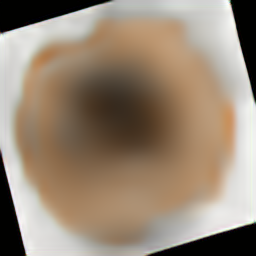

In [26]:
cv2_imshow(reconstruction_b[0])

In [27]:
rotten_score = []
for value in rotten_loss:
  rotten_score.append(np.array(value).mean())

<Figure size 640x480 with 0 Axes>

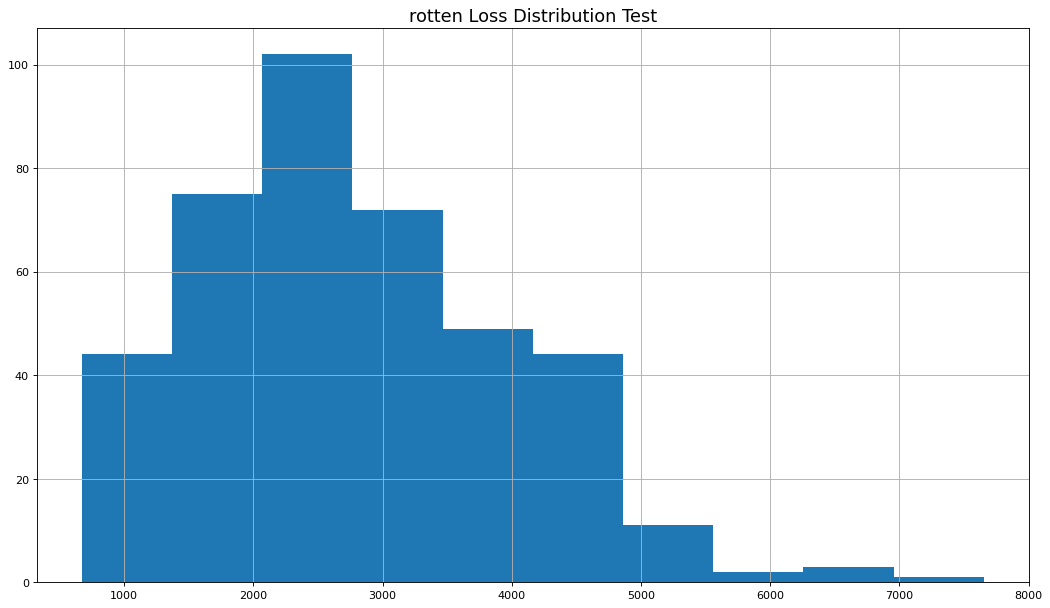

In [28]:
plt.figure()
plt.figure(figsize=(16,9), dpi=80)
plt.title('rotten Loss Distribution Test', fontsize=16)
plt.grid()
plt.hist(rotten_score, bins = 10);

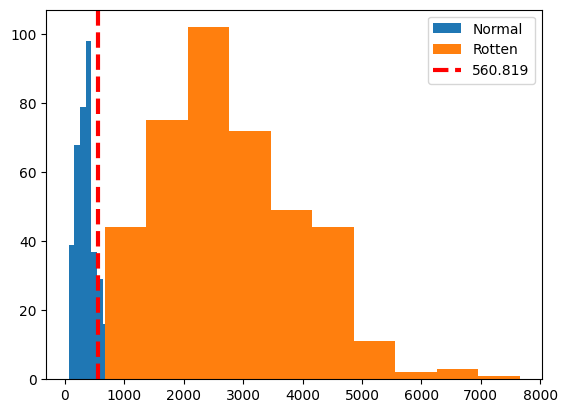

In [29]:
threshold = np.mean(normal_score) + np.std(normal_score)

plt.hist(normal_score, bins = 10, label = 'Normal')
# plt.hist(abnormal_score, bins = 10, label = 'Anomaly')
plt.hist(rotten_score, bins = 10, label = 'Rotten')
plt.axvline(threshold, color='r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(threshold))
plt.legend(loc = 'upper right')
plt.show()

In [30]:
true_label = np.concatenate((np.zeros((len(normal_score))), np.ones((len(rotten_score)))))
len(true_label)

791

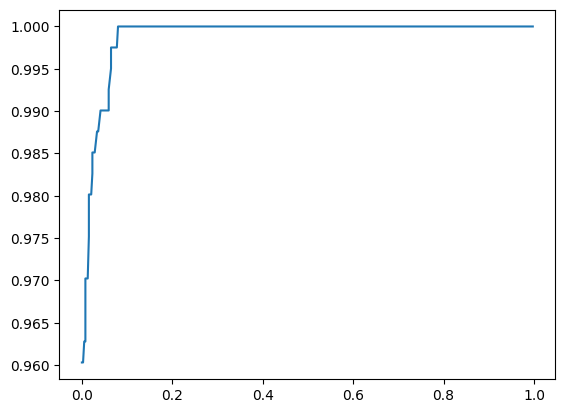

In [31]:
fprs = []; tprs = []

for threshold in thresholds:
  pred_label = predict_score(threshold, normal_score, rotten_score)
  fpr, tpr, _ = metrics.roc_curve(true_label, pred_label)
  fprs.append(fpr[1])
  tprs.append(tpr[1])

tprs = np.array([np.array(val) for val in tprs])
fprs = np.array([np.array(val) for val in fprs])
plt.plot(fprs, tprs)
plt.show()

In [32]:
tpr = pd.DataFrame(tprs)
fpr = pd.DataFrame(fprs)
tpr_csv_file = 'results/cae_tpr_orange.csv'
fpr_csv_file = 'results/cae_fpr_orange.csv'
with open(tpr_csv_file, mode='w') as f:
    tpr.to_csv(f)
with open(fpr_csv_file, mode='w') as f:
    fpr.to_csv(f)